In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%autosave 20

Autosaving every 20 seconds


In [2]:
from model import Net

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
from model import Net
from optimizer import get_optimizer,run_lrfinder
from model_fit import training,testing
from data_loader import MNISTDataLoader
from torch import nn
import json
import plotext as plt
import numpy as np
import random
import os
import sys
from rf_calc import receptive_field
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from itertools import islice
import datetime
import argparse

In [5]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # If using torch.backends.cudnn, set the following for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_model(device):
    model = Net().to(device)
    # model = model.float()
    return model

In [6]:
def run_model(model,device,batch_size,epochs,optimizer,scheduler,use_scheduler,best_model,version="v1",notes=""):

    current_lr = optimizer.param_groups[0]['lr']
    
    train_losses = []
    train_accuracy = []
    test_losses =[]Alt text
    print(summary(model, (1,28, 28 )))
    _ = receptive_field(model,28)

    for EPOCHS in range(0,epochs):
        train_loss, train_acc = training(model,device,train_loader,optimizer,EPOCHS)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        test_loss,test_acc = testing(model,device,test_loader,EPOCHS)
        test_accuracy.append(test_acc)
        test_losses.append(test_loss)
        
        if (scheduler_type == 'reducelronplateau') & (use_scheduler ==True):
            scheduler.step(test_loss)
            current_lr = optimizer.param_groups[0]['lr']
        elif (scheduler_type == 'steplr') & (use_scheduler ==True):
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
        else:
            current_lr = optimizer.param_groups[0]['lr']

        try:
            if len(test_accuracy) > Alt text
                    file_name = f"./model_folder/modelbest_{test_accuracy[-1]:.4f}_epoch_{EPOCHS}.pt"
                    torch.save(checkpoint, file_name)
                    print(f"Target Achieved: {max(test_accuracy) * 100:.2f}% Test Accuracy!!")
                else:
                    print("Conditions not met for saving the model.")
            else:
                print("Insufficient test accuracy data.")
        except Exception as e:
            print(f"Model saving failed: {e}")

        print(f"LR: {current_lr}\n")
    return model,train_losses, train_accuracy,test_losses,test_accuracy

In [7]:
def load_config():
    with open('config.json', 'r') as f:
        return json.load(f)

In [8]:
def get_loss_function(loss_type):
    if loss_type is None:
        return nn.NLLLoss()   
    loss_types = {
        'cross_entropy': nn.CrossEntropyLoss(),
        'mse': nn.MSELoss(),
        'nll': nn.NLLLoss()
    }
    return loss_types.get(loss_type.lower(), nn.CrossEntropyLoss())

In [9]:
config = load_config()

# Set seed from config
set_seed(config['seed'])

In [10]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Get loss function and scheduler settings from config
loss_fn = get_loss_function(config['training'].get('loss_type'))
use_scheduler = config['training'].get('use_scheduler', False)
scheduler_type = config['training'].get('scheduler_type', 'steplr')
runlr_finer = config['training'].get('runlr_finer', False)
use_scheduler = bool(use_scheduler)
runlr_finer = bool(runlr_finer)

In [11]:
best_model = config['best_model']
version = 'v1'
notes = config['training'].get('notes', '')

In [12]:
# Set seed from config
_ = torch.manual_seed(config['seed'])
if torch.cuda.is_available():
    _ = torch.cuda.manual_seed(config['seed'])

In [13]:
# Get batch size based on device
batch_size = config['training']['batch_size']
epochs = config['training']['epochs']

In [14]:
model = get_model(device)
data_loader = MNISTDataLoader(batch_size=batch_size)
train_loader, test_loader = data_loader.get_data_loaders()

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 3495/4500 [00:30<00:08, 113.83it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.01E-01


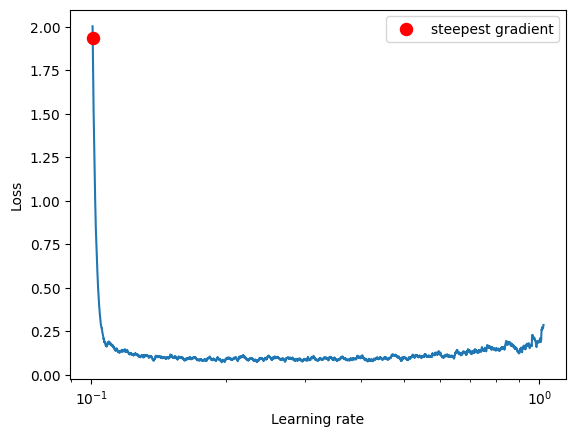

Loss: 0.07299442993729771 LR: 0.10073514187592006
[0.10073514187592006]


In [15]:
if runlr_finer:
    lrs,_ = run_lrfinder(
        model, 
        device, 
        train_loader, 
        test_loader, 
        start_lr=config['training']['start_lr'],
        end_lr=config['training']['end_lr'],
            lr_iter=config['training'].get('lr_iter', 1000)
        )
    print(lrs)
else:
    lrs = [0.015]

In [16]:
optimizer,scheduler = get_optimizer(model,scheduler = use_scheduler,\
                          scheduler_type = scheduler_type,lr = lrs[0])

In [17]:
model,train_losses, train_accuracy,test_losses,test_accuracy= run_model(model,device,batch_size,epochs,optimizer,scheduler,use_scheduler,best_model,version,notes)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 15, 22, 22]           1,350
      BatchNorm2d-10           [-1, 15, 22, 22]              30
             ReLU-11           [-1, 15, 22, 22]               0
          Dropout-12           [-1, 15, 22, 22]               0
        MaxPool2d-13           [-1, 15, 11, 11]               0
           Conv2d-14           [-1, 10,

Train ==> Epochs: 0 Batch:  468 loss: 0.0664239153265953 Accuracy: 92.86% : 100%|██████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.63it/s]
Test ==> Epochs: 0 Batch:  78 loss: 0.057483961629867554 Accuracy: 98.24% : 100%|████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 174.17it/s]


Insufficient test accuracy data.
LR: 0.10073514187592006



Train ==> Epochs: 1 Batch:  468 loss: 0.13325758278369904 Accuracy: 96.81% : 100%|█████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.89it/s]
Test ==> Epochs: 1 Batch:  78 loss: 0.04129311885237694 Accuracy: 98.52% : 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 175.05it/s]


Conditions not met for saving the model.
LR: 0.10073514187592006



Train ==> Epochs: 2 Batch:  468 loss: 0.029430197551846504 Accuracy: 97.33% : 100%|████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.02it/s]
Test ==> Epochs: 2 Batch:  78 loss: 0.033250286853313445 Accuracy: 98.87% : 100%|████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 182.39it/s]


Conditions not met for saving the model.
LR: 0.10073514187592006



Train ==> Epochs: 3 Batch:  468 loss: 0.028518887236714363 Accuracy: 97.58% : 100%|████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.92it/s]
Test ==> Epochs: 3 Batch:  78 loss: 0.029331215238384903 Accuracy: 98.95% : 100%|████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 188.19it/s]


Conditions not met for saving the model.
LR: 0.10073514187592006



Train ==> Epochs: 4 Batch:  468 loss: 0.06851861625909805 Accuracy: 97.83% : 100%|█████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.27it/s]
Test ==> Epochs: 4 Batch:  78 loss: 0.03591104096397758 Accuracy: 98.86% : 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 187.40it/s]


Conditions not met for saving the model.
LR: 0.10073514187592006



Train ==> Epochs: 5 Batch:  468 loss: 0.07560386508703232 Accuracy: 97.86% : 100%|█████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.82it/s]
Test ==> Epochs: 5 Batch:  78 loss: 0.02452789550870657 Accuracy: 99.21% : 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 180.82it/s]


Conditions not met for saving the model.
LR: 0.10073514187592006



Train ==> Epochs: 6 Batch:  468 loss: 0.0420493483543396 Accuracy: 98.05% : 100%|██████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.53it/s]
Test ==> Epochs: 6 Batch:  78 loss: 0.029527589478343726 Accuracy: 99.03% : 100%|████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 180.65it/s]


Conditions not met for saving the model.
LR: 0.10073514187592006



Train ==> Epochs: 7 Batch:  468 loss: 0.2726905047893524 Accuracy: 98.05% : 100%|██████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.68it/s]
Test ==> Epochs: 7 Batch:  78 loss: 0.02484587676525116 Accuracy: 99.22% : 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 182.43it/s]


Conditions not met for saving the model.
LR: 0.0010073514187592006



Train ==> Epochs: 8 Batch:  468 loss: 0.010433562099933624 Accuracy: 98.30% : 100%|████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.46it/s]
Test ==> Epochs: 8 Batch:  78 loss: 0.02171391881033778 Accuracy: 99.30% : 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 183.75it/s]


Target Achieved: 99.30% Test Accuracy!!
LR: 0.0010073514187592006



Train ==> Epochs: 9 Batch:  468 loss: 0.008846824057400227 Accuracy: 98.37% : 100%|████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.85it/s]
Test ==> Epochs: 9 Batch:  78 loss: 0.021358877968252636 Accuracy: 99.36% : 100%|████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 187.69it/s]


Target Achieved: 99.36% Test Accuracy!!
LR: 0.0010073514187592006



Train ==> Epochs: 10 Batch:  468 loss: 0.06159461662173271 Accuracy: 98.54% : 100%|████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.17it/s]
Test ==> Epochs: 10 Batch:  78 loss: 0.02165997515451163 Accuracy: 99.29% : 100%|████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 189.23it/s]


Conditions not met for saving the model.
LR: 0.0010073514187592006



Train ==> Epochs: 11 Batch:  468 loss: 0.08736568689346313 Accuracy: 98.50% : 100%|████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.23it/s]
Test ==> Epochs: 11 Batch:  78 loss: 0.0206610428201966 Accuracy: 99.37% : 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 182.63it/s]


Target Achieved: 99.37% Test Accuracy!!
LR: 0.0010073514187592006



Train ==> Epochs: 12 Batch:  468 loss: 0.05075821280479431 Accuracy: 98.53% : 100%|████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.93it/s]
Test ==> Epochs: 12 Batch:  78 loss: 0.02067163370102644 Accuracy: 99.35% : 100%|████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 173.38it/s]


Conditions not met for saving the model.
LR: 0.0010073514187592006



Train ==> Epochs: 13 Batch:  468 loss: 0.0322054848074913 Accuracy: 98.52% : 100%|█████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.38it/s]
Test ==> Epochs: 13 Batch:  78 loss: 0.020491335131321103 Accuracy: 99.36% : 100%|███████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 189.94it/s]


Conditions not met for saving the model.
LR: 0.001



Train ==> Epochs: 14 Batch:  468 loss: 0.011806813068687916 Accuracy: 98.49% : 100%|███████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.64it/s]
Test ==> Epochs: 14 Batch:  78 loss: 0.019897268631123007 Accuracy: 99.36% : 100%|███████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 186.28it/s]


Conditions not met for saving the model.
LR: 0.001



Train ==> Epochs: 15 Batch:  468 loss: 0.06301724910736084 Accuracy: 98.56% : 100%|████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.31it/s]
Test ==> Epochs: 15 Batch:  78 loss: 0.02013821913860738 Accuracy: 99.38% : 100%|████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 179.20it/s]


Target Achieved: 99.38% Test Accuracy!!
LR: 0.001



Train ==> Epochs: 16 Batch:  468 loss: 0.049461644142866135 Accuracy: 98.54% : 100%|███████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.80it/s]
Test ==> Epochs: 16 Batch:  78 loss: 0.019710084308683873 Accuracy: 99.37% : 100%|███████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 167.15it/s]


Conditions not met for saving the model.
LR: 0.001



Train ==> Epochs: 17 Batch:  468 loss: 0.020712172612547874 Accuracy: 98.50% : 100%|███████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.10it/s]
Test ==> Epochs: 17 Batch:  78 loss: 0.019968891701102255 Accuracy: 99.39% : 100%|███████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 177.99it/s]


Target Achieved: 99.39% Test Accuracy!!
LR: 0.001



Train ==> Epochs: 18 Batch:  468 loss: 0.036966774612665176 Accuracy: 98.62% : 100%|███████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.71it/s]
Test ==> Epochs: 18 Batch:  78 loss: 0.019740125006437303 Accuracy: 99.40% : 100%|███████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 173.32it/s]


Target Achieved: 99.40% Test Accuracy!!
LR: 0.001



Train ==> Epochs: 19 Batch:  468 loss: 0.021130099892616272 Accuracy: 98.59% : 100%|███████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.46it/s]
Test ==> Epochs: 19 Batch:  78 loss: 0.019408639186713844 Accuracy: 99.38% : 100%|███████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 174.77it/s]

Conditions not met for saving the model.
LR: 0.001



In [18]:
print("Max Train Accuracy: ",max(train_accuracy))
print("Max Test Accuracy: ",max(test_accuracy))

Max Train Accuracy:  0.9862166666666666
Max Test Accuracy:  0.994


Text(0.5, 1.0, 'Model Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Model Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

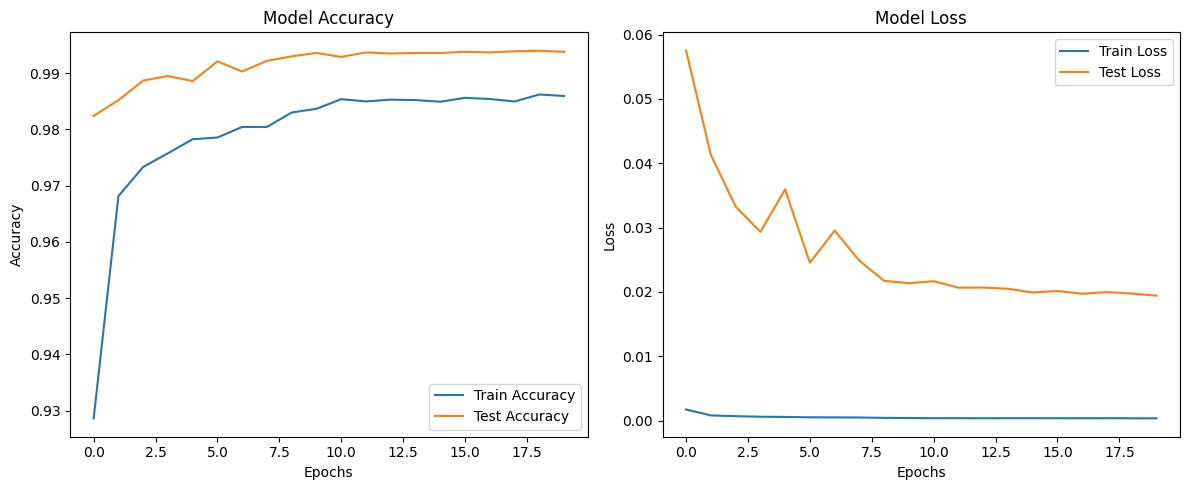

In [19]:
import matplotlib.pyplot as plt
# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot accuracy on the first subplot
axes[0].plot(train_accuracy, label="Train Accuracy")
axes[0].plot(test_accuracy, label="Test Accuracy")
axes[0].set_title("Model Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# Plot loss on the second subplot
axes[1].plot(train_losses, label="Train Loss")
axes[1].plot(test_losses, label="Test Loss")
axes[1].set_title("Model Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### Infrencing 

2024-11-29 20:45:46,439 - INFO - Loading configuration...
2024-11-29 20:45:46,440 - INFO - Using device: cuda
2024-11-29 20:45:46,453 - INFO - Loading model: modelbest_0.9946_epoch_18.pt
2024-11-29 20:45:46,462 - INFO - Model loaded successfully.
2024-11-29 20:45:55,618 - INFO - Starting validation on train dataset...
Validating train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 31.99batch/s]
2024-11-29 20:46:10,282 - INFO - Number of incorrect predictions in train dataset: 728
2024-11-29 20:46:10,282 - INFO - Starting validation on test dataset...
Validating test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.34batch/s]
2024-11-29 20:46:11,347 - INFO - Number of incorrect predictions in test dataset: 54


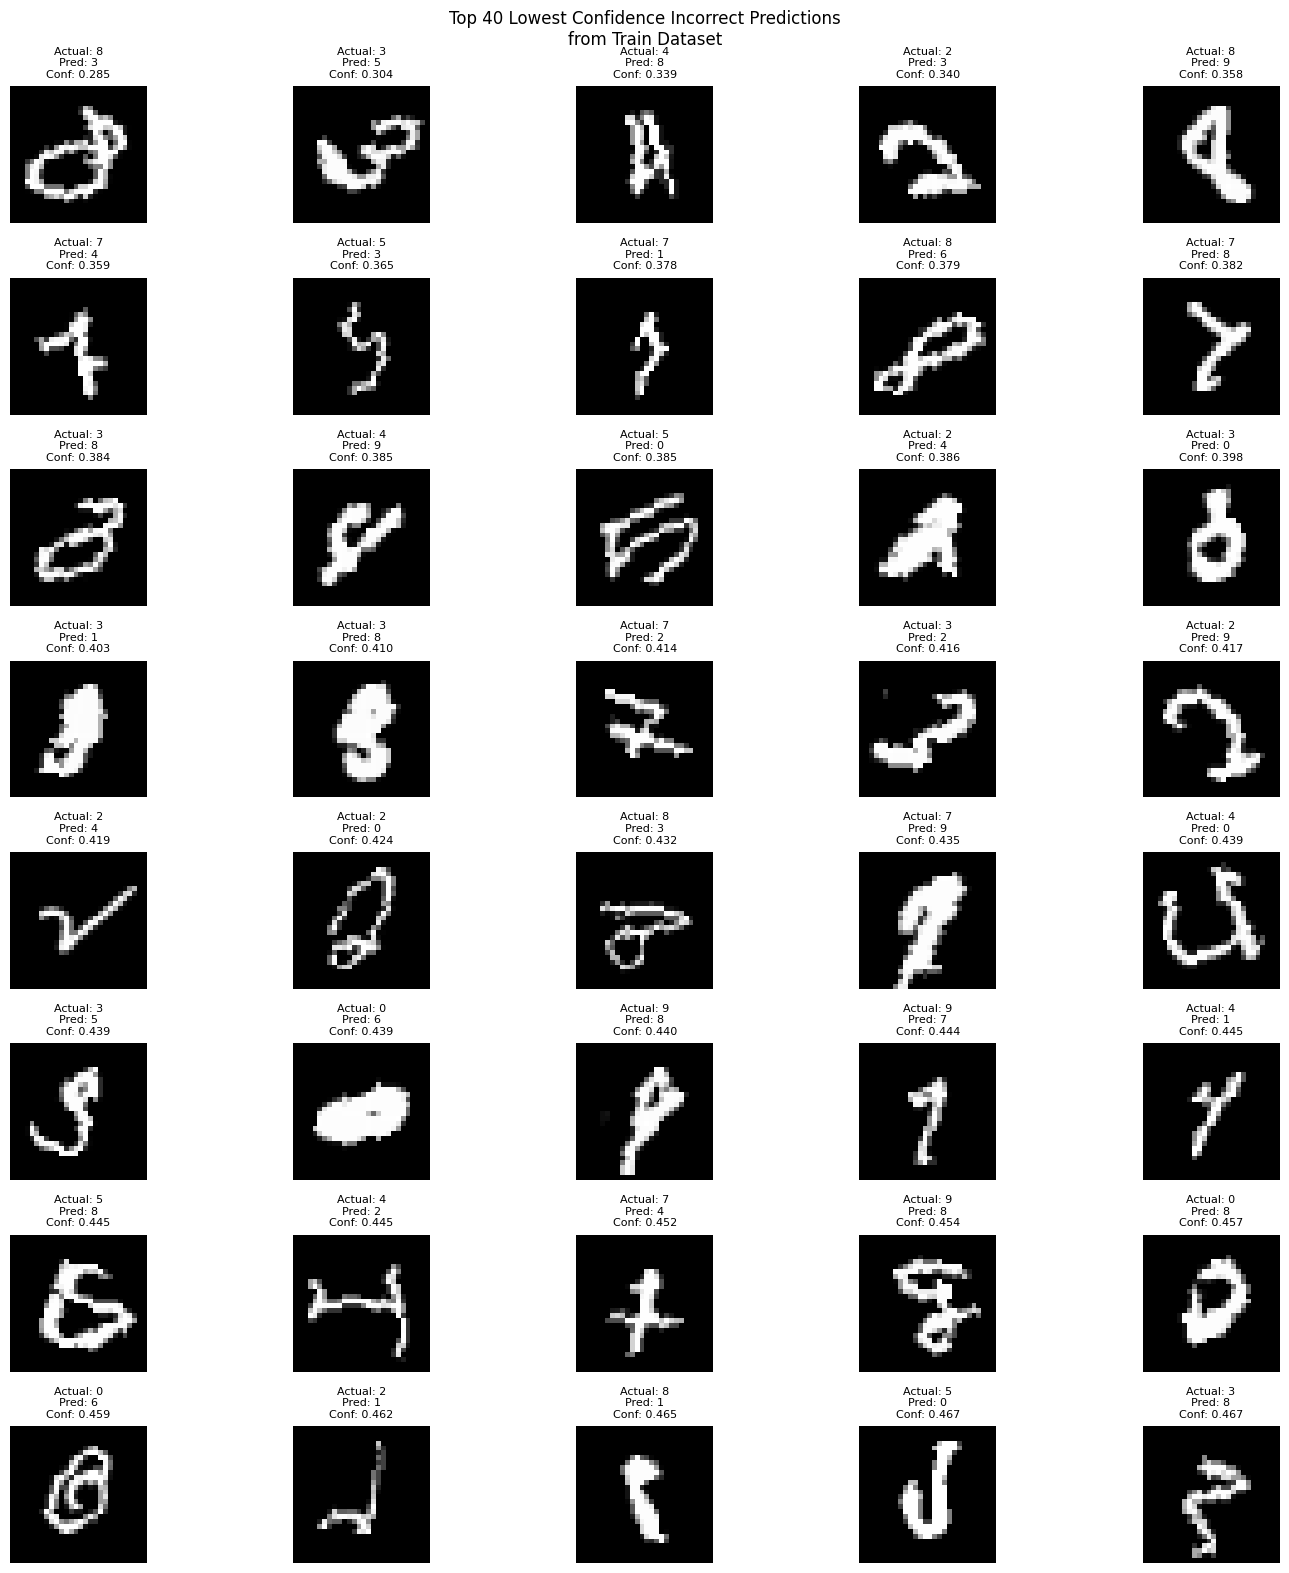

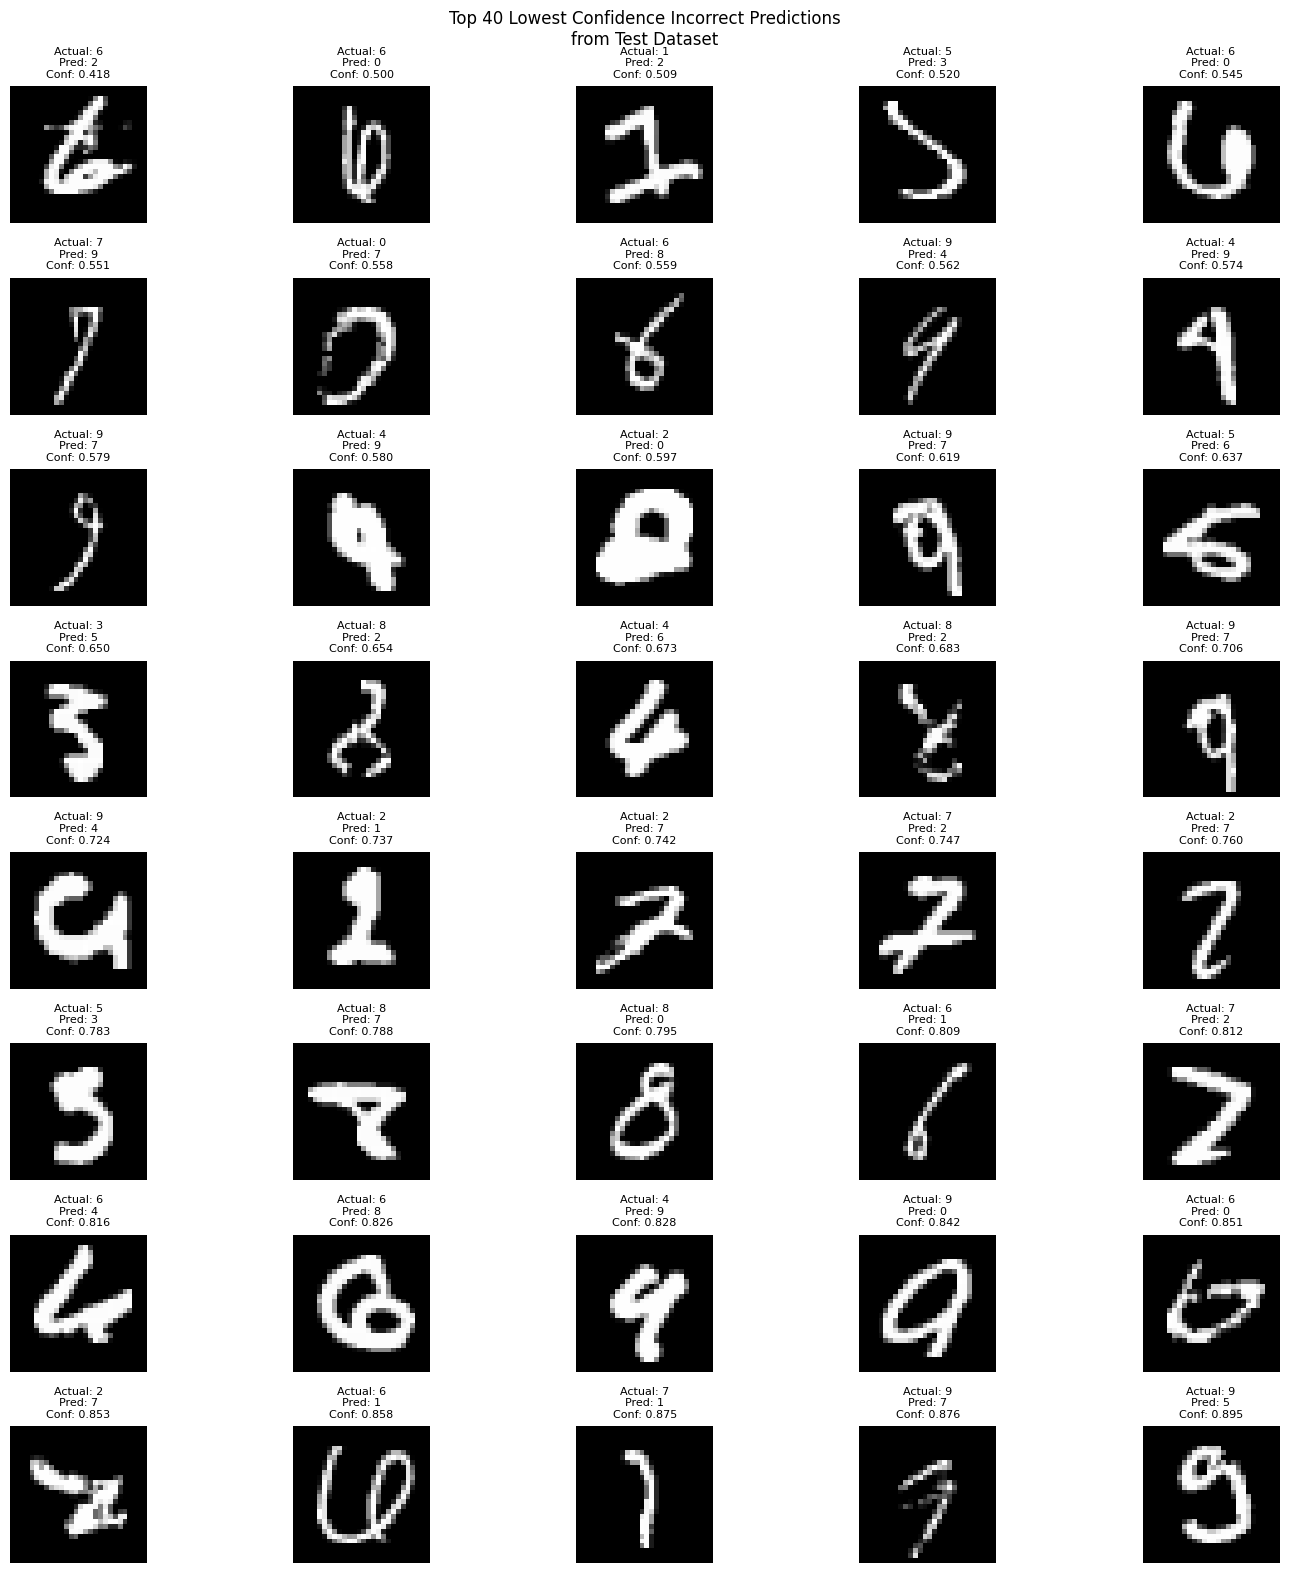

In [21]:
import warnings
warnings.filterwarnings('ignore')

import logging
from tqdm import tqdm
import torch
from torchvision import transforms
from PIL import Image
from model import Net
import json
import os
import sys
from data_loader import MNISTDataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset, ConcatDataset
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set up the path for the model and configuration
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

def load_best_model(path="", device="cuda"):
    scores = []
    for index, file in enumerate(os.listdir(path)):
        if file.endswith(".pt"):
            scores.append(float(file.split("_")[1]))

    best_score = max(scores)
    max_acc = scores.index(best_score)
    name = os.listdir(path)[max_acc]
    model = Net().to(device)

    # Log the model being loaded
    logging.info(f"Loading model: {name}")

    # Load the state_dict from the saved model with weights_only=True
    checkpoint = torch.load(f'./model_folder/{name}', map_location=device, weights_only=True)

    # Load only the matching parameters
    model_dict = model.state_dict()
    pretrained_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

    # Filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].size() == v.size()}

    # Overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    model.eval()
    return model

def infer(model, device, image_path, mean, std):
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1, keepdim=True)  # Get the predicted class

    return prediction.item()  # Return the predicted class as an integer

def load_config():
    with open('config.json', 'r') as f:
        return json.load(f)

def get_data_loaders(mean, std):
    train_transforms = transforms.Compose([
        transforms.Resize((28, 28)),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=transforms.InterpolationMode.NEAREST),
        transforms.RandomRotation(degrees=15, expand=False, center=None, fill=(mean) ),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])
    
    train_data = datasets.MNIST(
        root='.data',
        train=True,
        download=True,
        transform=train_transforms  # Use train_transforms
    )

    test_data = datasets.MNIST(
        root='.data',
        train=False,
        download=True,
        transform=test_transforms  # Use test_transforms
    )
    
    return train_data, test_data

def validate_model(model, device, data_loader, source):
    model.eval()
    incorrect_predictions = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc=f"Validating {source}", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]
            
            for index in incorrect_indices:
                # Get the confidence score (maximum probability)
                confidence = torch.softmax(outputs[index], dim=0).max().item()
                incorrect_predictions.append({
                    'image': images[index].cpu(),
                    'predicted': predicted[index].cpu().item(),
                    'actual': labels[index].cpu().item(),
                    'confidence': confidence,  # Store the confidence score
                    'source': source
                })
    
    # Sort by confidence score in ascending order
    incorrect_predictions.sort(key=lambda x: x['confidence'])
    return incorrect_predictions

def plot_incorrect_predictions(incorrect_data, max_images=20, source=""):
    num_incorrect = len(incorrect_data)
    num_to_plot = min(num_incorrect, max_images)
    cols = 5
    rows = (num_to_plot // cols) + (num_to_plot % cols > 0)

    plt.figure(figsize=(15, rows * 2))
    for i, item in enumerate(incorrect_data[:num_to_plot]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(item['image'].squeeze(), cmap='gray')
        plt.title(f'Actual: {item["actual"]}\nPred: {item["predicted"]}\nConf: {item["confidence"]:.3f}', 
                 fontsize=8)
        plt.axis('off')

    plt.suptitle(f"Top {num_to_plot} Lowest Confidence Incorrect Predictions\nfrom {source} Dataset", 
                fontsize=12)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    logging.info("Loading configuration...")
    config = load_config()
    
    # Set device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    logging.info(f"Using device: {device}")
    
    # Load model
    model_path = './model_folder/'  # Specify the correct path to your model folder
    model = load_best_model(model_path, device)  # Pass the model path and device
    logging.info("Model loaded successfully.")
    
    # Create an instance of MNISTDataLoader to get mean and std
    data_loader_instance = MNISTDataLoader()
    mean_val, std_val = data_loader_instance._calculate_stats()  # Get mean and std values

    # Get train and test datasets
    train_data, test_data = get_data_loaders(mean_val, std_val)

    # Create DataLoaders for train and test datasets with batch size 128
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

    # Validate the model and get incorrect predictions for train and test datasets
    logging.info("Starting validation on train dataset...")
    incorrect_train_data = validate_model(model, device, train_loader, "train")
    logging.info(f'Number of incorrect predictions in train dataset: {len(incorrect_train_data)}')

    logging.info("Starting validation on test dataset...")
    incorrect_test_data = validate_model(model, device, test_loader, "test")
    logging.info(f'Number of incorrect predictions in test dataset: {len(incorrect_test_data)}')

    # Plot incorrect predictions
    plot_incorrect_predictions(incorrect_train_data, max_images=40, source="Train")
   

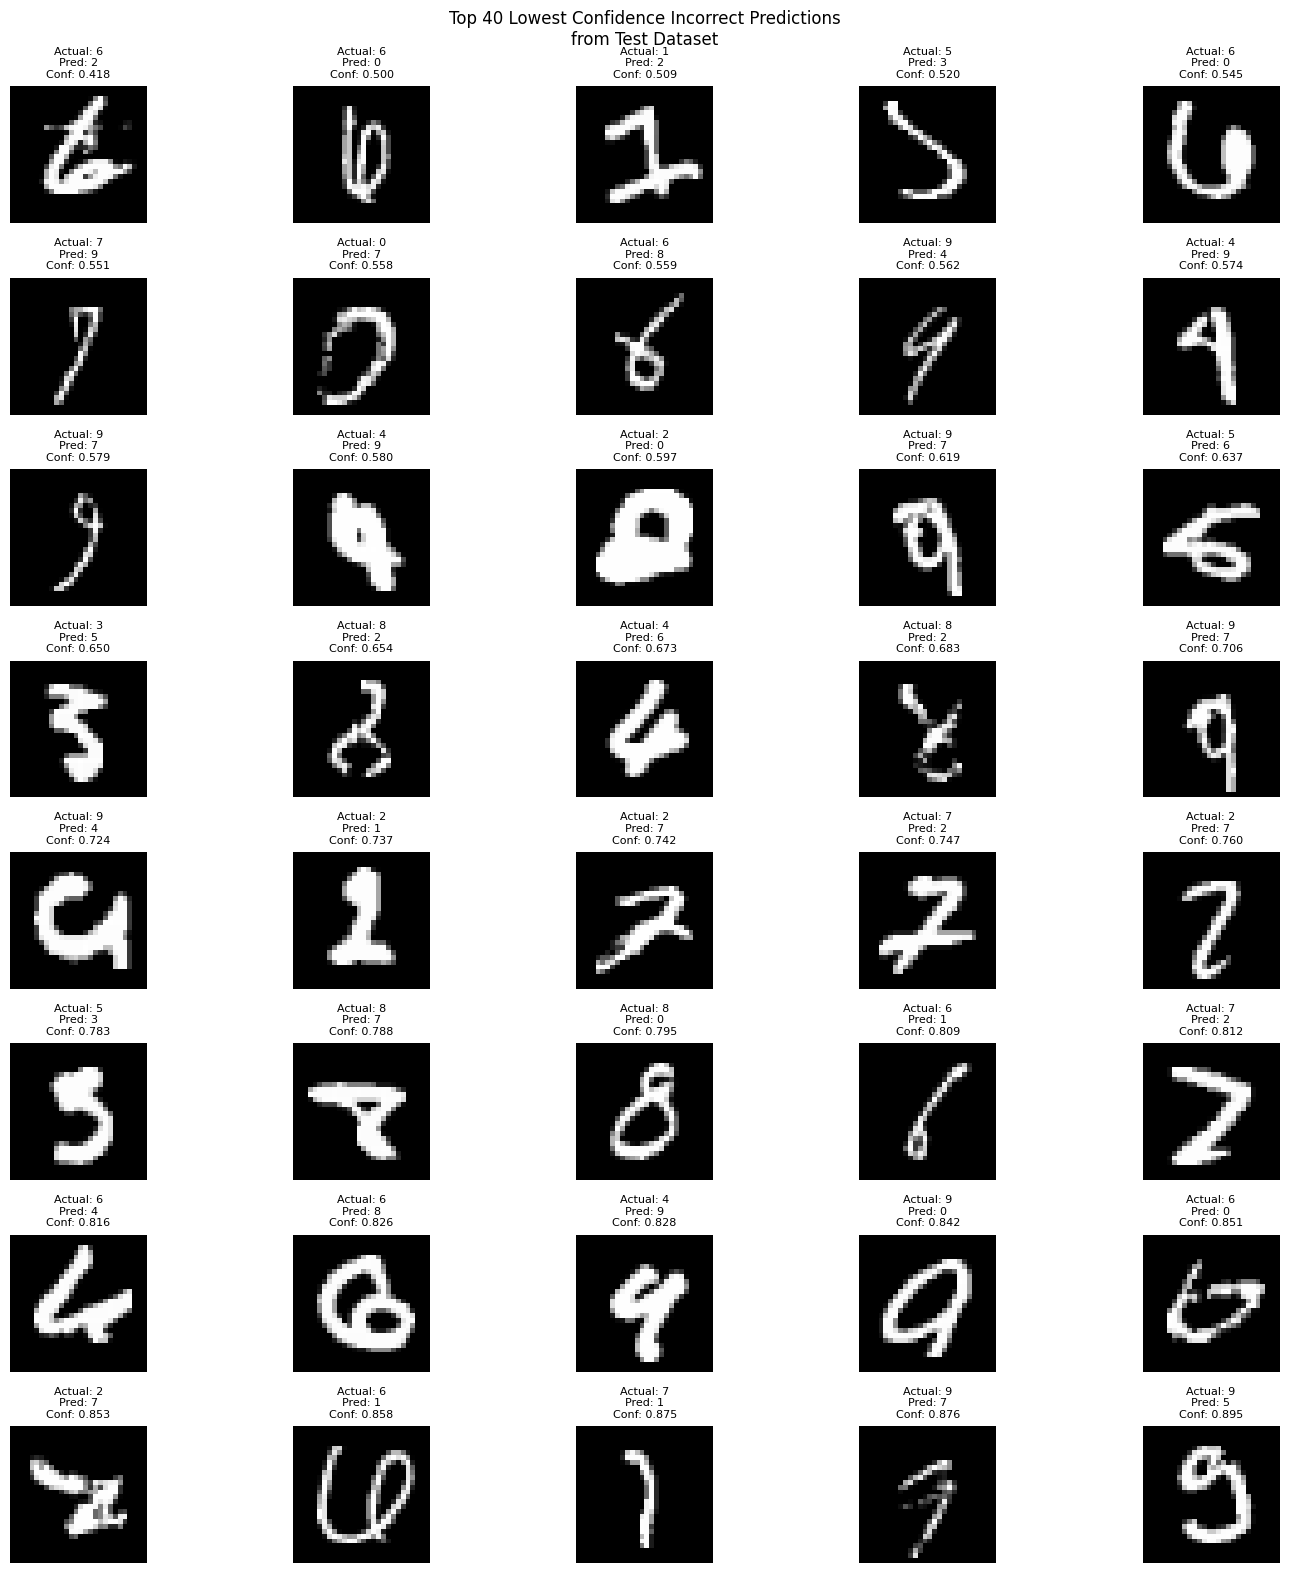

In [22]:
 plot_incorrect_predictions(incorrect_test_data, max_images=40, source="Test")